<a href="https://colab.research.google.com/github/bc0de0/LinearRegression/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf


In [ ]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
print(y_train)
print(dfeval)

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64
        sex   age  n_siblings_spouses  parch     fare   class     deck  \
0      male  35.0                   0      0   8.0500   Third  unknown   
1      male  54.0                   0      0  51.8625   First        E   
2    female  58.0                   0      0  26.5500   First        C   
3    female  55.0                   0      0  16.0000  Second  unknown   
4      male  34.0                   0      0  13.0000  Second        D   
..      ...   ...                 ...    ...      ...     ...      ...   
259  female  25.0                   0      1  26.0000  Second  unknown   
260    male  33.0                   0      0   7.8958   Third  unknown   
261  female  39.0                   0      5  29.1250   Third  unknown   
262    male  27.0                   0      0  13.0000  Second  unknown   
263    male  26.0                   0      0 

In [ ]:
print(dftrain.loc[0], y_train[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [ ]:
dftrain.shape

(627, 9)

In [ ]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

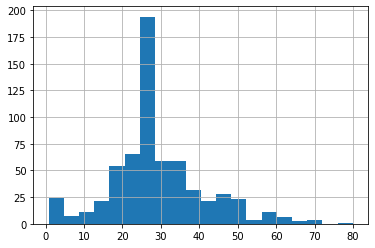

In [ ]:
dftrain.age.hist(bins=20)

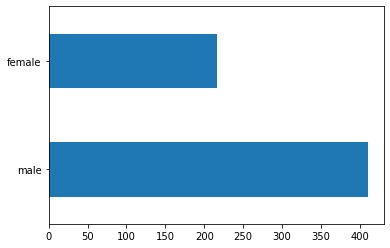

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

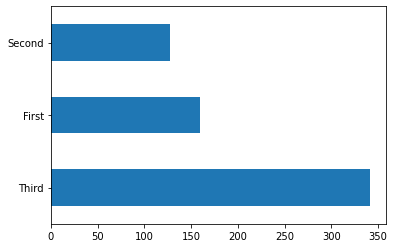

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

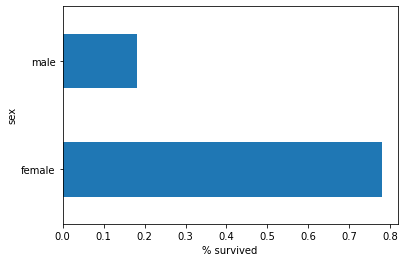

In [20]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

In [21]:
dfeval.shape

(264, 9)

In [23]:
CATAGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATAGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.sequence_categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.int32))

print(feature_columns)

[SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_co

In [30]:
from numpy.ma.core import outer
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_function = make_input_fn(dftrain, y_train)
eval_input_function = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

linear_est.train(train_input_function)
result = linear_est.evaluate(eval_input_function)
clear_output()
print(result['accuracy'])


0.7386364
{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.8307316, 'auc_precision_recall': 0.7984495, 'average_loss': 0.47580597, 'label/mean': 0.375, 'loss': 0.46743998, 'precision': 0.6530612, 'prediction/mean': 0.4006793, 'recall': 0.64646465, 'global_step': 200}


In [31]:
result = list(linear_est.predict(eval_input_function))
print(result)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1nwu5dqf/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'logits': array([-2.3049006], dtype=float32), 'logistic': array([0.09071791], dtype=float32), 'probabilities': array([0.9092821, 0.0907179], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.35108978], dtype=float32), 'logistic': array([0.41311818], dtype=float32), 'probabilities': array([0.5868818, 0.4131182], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([1.3402723], dtype=float32), 'logistic': array([0.7925347], dtype=float32), 'probabilities': array([0.20746529

In [32]:
print(result[0])

{'logits': array([-2.3049006], dtype=float32), 'logistic': array([0.09071791], dtype=float32), 'probabilities': array([0.9092821, 0.0907179], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}


In [33]:
print(result[0]['probabilities'])

[0.9092821 0.0907179]


In [36]:
print(result[0]['probabilities'][1])

0.090717904


In [40]:
print(dfeval.loc[0])
print(result[0]['probabilities'][1])


sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0.090717904
